# Tutorial 11a - Random Forest Regressor to Predict Optimal Lens Properties
### Building a Random Forest Regressor to Predict Optimal Lens Properties

This notebook demonstrates how to build and train a random forest regressor to predict the radius of curvature of a plano-convex lens in order to minimize the RMS spot size.

#### Steps Included:

1. **Data Preparation**: Generate and preprocess a dataset of optimal lens designs.
2. **Model Training**: Train the random forest regressor using the prepared dataset.
3. **Model Evaluation**: Evaluate the performance of the trained model.
4. **Prediction**: Use the trained model to predict the optimal radius of curvature for new lens parameters to minimize the RMS spot size.

In [1]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from tqdm import tqdm

from optiland import analysis, materials, optic, optimization

## Build a configurable plano-convex singlet

We start by defining a class, which parameterizes a plano-convex lens based on three properties:

1. Entrance Pupil Diameter (EPD) in mm
2. Index of refraction at 587 nm
3. Radius of curvature of the lens front surface

In [2]:
class ConfigurableSinglet(optic.Optic):
    """A class to represent a configurable singlet lens.

    This class inherits from the `optic.Optic` class and allows for the creation
    of a singlet lens with configurable parameters: entrance pupil diameter (EPD),
    refractive index (n), and radius of curvature (R). The lens thickness is fixed
    at 1/5 of the entrance pupil diameter to maintain a reasonable aspect ratio.

    Attributes:
        epd (float): Entrance pupil diameter.
        n (float): Refractive index of the lens material.
        R (float): Radius of curvature of the lens.

    """

    def __init__(self, epd, n, R):
        super().__init__()

        mat = materials.IdealMaterial(n=n)

        # add surfaces
        self.add_surface(index=0, radius=np.inf, thickness=np.inf)
        self.add_surface(
            index=1,
            radius=R,
            thickness=epd / 5,
            is_stop=True,
            material=mat,
        )
        self.add_surface(index=2, radius=np.inf, thickness=15)
        self.add_surface(index=3)

        # add aperture
        self.set_aperture(aperture_type="EPD", value=epd)

        # add field
        self.set_field_type(field_type="angle")
        self.add_field(y=0)

        # add wavelength
        self.add_wavelength(value=0.587, is_primary=True)

        # move image plane to paraxial focus
        self.image_solve()

## Generate and draw a lens

This is an example of one possible lens configuration.

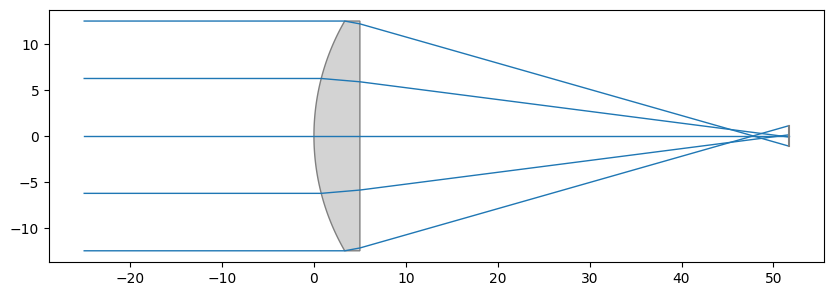

In [3]:
lens = ConfigurableSinglet(epd=25, n=1.5, R=25)
lens.draw(num_rays=5)

## Data preparation

We build a dataset that we will use to train our random forest regressor. The ultimate goal of the predictive model will be to predict the radius of curvature of our plano-convex lens given the lens f-number and the refractive index (at 587 nm). We will run 2500 simulations, each with a different f-number and refractive index. We choose the following ranges of our variables:

- F-number: 2 to 10
- Refractive Index: 1.4 to 2.0

In [4]:
fno = np.linspace(2, 10, 50)
n = np.linspace(1.4, 2.0, 50)

# Total number of simulations = 50^2 = 2500
fno, n = np.meshgrid(fno, n)
fno = fno.ravel()
n = n.ravel()

### Generate helper function for optimization

This function will identify the optimal singlet, given the f-number and refractive index of the lens.

In [5]:
def optimize_lens(lens):
    # Define empty optimization problem
    problem = optimization.OptimizationProblem()

    # Add target for RMS spot size - use on-axis field and a hexapolar distribution
    # Surface number is set to -1 to indicate the image plane
    input_data = {
        "optic": lens,
        "surface_number": -1,
        "Hx": 0,
        "Hy": 0,
        "num_rays": 5,
        "wavelength": 0.587,
        "distribution": "hexapolar",
    }
    problem.add_operand(
        operand_type="rms_spot_size",
        target=0,
        weight=10,
        input_data=input_data,
    )

    # Add target for focal length
    problem.add_operand(
        operand_type="f2",
        target=20,
        weight=1,
        input_data={"optic": lens},
    )

    # Allow the thickness to image plane and the radius of curvature to vary
    problem.add_variable(lens, "radius", surface_number=1)  # first lens surface
    problem.add_variable(lens, "thickness", surface_number=2)

    # Define optimizer
    optimizer = optimization.OptimizerGeneric(problem)

    # Optimize - ignore warnings if ray errors occur
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        optimizer.optimize(tol=1e-6)

    # Retrieve optimized rms spot size
    rms_spot_size = problem.operands[0].value

    # Retrieve optimized focal length
    f_opt = problem.operands[1].value

    return lens, rms_spot_size, f_opt

### Optimize lenses

We will record all data in a pandas dataframe. Without loss of generality, we fix the lens focal length to 20 mm. During optimization, we also enforce this.

In [6]:
df = pd.DataFrame({"FNO": fno, "n": n})

df["EPD"] = 20 / df["FNO"]

# Variables to store the optimized values
df["R_opt"] = np.nan
df["rms_spot_size"] = np.nan
df["f_opt"] = np.nan

Run optimization for 2500 systems. This takes 3-4 minutes on the author's machine.

In [7]:
for k, row in tqdm(df.iterrows(), total=len(df)):
    # Generate starting lens
    lens = ConfigurableSinglet(epd=row["EPD"], n=row["n"], R=15)

    # Optimize lens
    lens, rms_spot_size, f_opt = optimize_lens(lens)

    # Store optimized values
    df.loc[k, "R_opt"] = lens.surface_group.radii[1]
    df.loc[k, "rms_spot_size"] = rms_spot_size
    df.loc[k, "f_opt"] = f_opt

100%|██████████| 2500/2500 [03:38<00:00, 11.44it/s]


## Explore the dataset

Not all systems may have been fully optimized, so we will exclude these when building the random forest model. We can check for optimization success by comparing the resulting focal length to our target of 20 mm.

In [8]:
df["optimization_success"] = (
    np.abs(df["f_opt"] - 20) < 0.01
)  # choose a tolerance of 0.01 mm

# View the number of successes and failures
df["optimization_success"].value_counts()

optimization_success
True     2352
False     148
Name: count, dtype: int64

### Investigate correlations between lens properties and optimized results.

<Axes: >

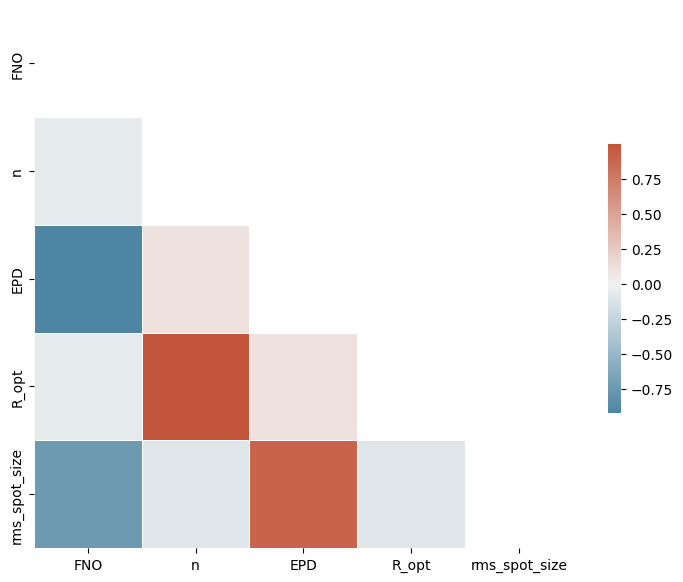

In [9]:
# Get dataframe of successful optimizations
df_success = df[df.optimization_success]

# Compute correlation matrix (exclude optimization_success & focal length columns)
corr = df_success.drop(columns=["optimization_success", "f_opt"]).corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(9, 7))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(
    corr,
    mask=mask,
    cmap=cmap,
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.5},
)

We identify a few relationships:

1. Larger refractive indices generally result in larger optimal radii of curvature.
2. Larger f-numbers result in smaller achieved RMS spot sizes.

### Plot relationship between FNO, refractive index, and achieved RMS spot size (mm)

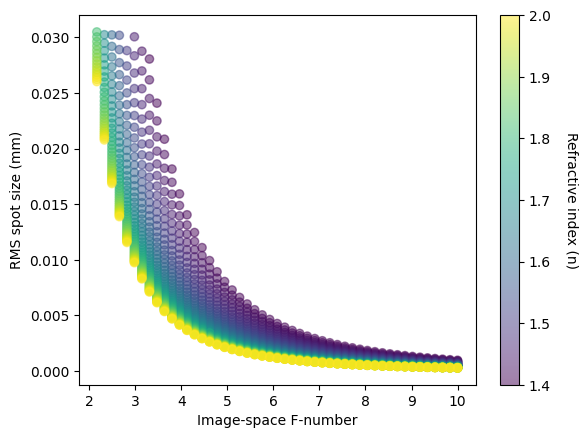

In [10]:
plt.scatter(df_success.FNO, df_success.rms_spot_size, c=df_success.n, alpha=0.5)
plt.xlabel("Image-space F-number")
plt.ylabel("RMS spot size (mm)")
cbar = plt.colorbar()
cbar.set_label("Refractive index (n)", rotation=270, labelpad=20)
plt.show()

This plot shows that there appears to be an RMS spot size minimum, which varies with f-number. We also see that larger refractive indices appear to result in smaller RMS spot sizes, which appears as a gradient-like effect that can especially be seen at smaller f-numbers.

## Build Predictive Model

Split data into features and target variable

In [11]:
X = df_success[["n", "FNO"]]
y = df_success["R_opt"]

Split the data into training and testing sets

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
)

Train regression model

In [13]:
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

Evaluate the model

In [14]:
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse:.3e}")

Mean Squared Error: 2.457e-07


Based on the resulting mean squared error on the test dataset, we can see that the model has successfully captured the relationships in the dataset.

## Prediction

We now choose new parameters for the refractive index and f-number and use our random forest model to predict the radius of curvature. We compute the RMS spot size and plot the spot diagram to confirm the resulting lens indeed reaches a minimal spot size.

In [35]:
new_data = pd.DataFrame({"n": [1.864], "FNO": [5.45]})  # Example new data
prediction = model.predict(new_data)
print(f"Predicted Radius of Curvature: {prediction[0]:.2f} mm")

Predicted Radius of Curvature: 17.31 mm


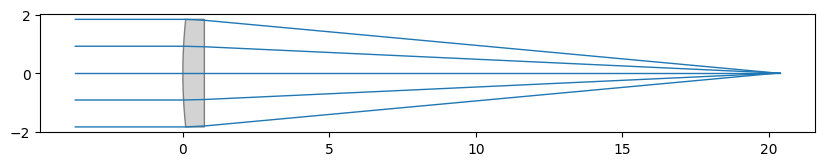

In [36]:
lens = ConfigurableSinglet(epd=20 / 5.45, n=1.864, R=prediction[0])
lens.draw(num_rays=5)

In [37]:
spot = analysis.SpotDiagram(lens)
print(
    f"RMS Spot Size: {spot.rms_spot_radius()[0][0]:.4f} mm",
)  # field index 0 and wavelength index 0

RMS Spot Size: 0.0052 mm


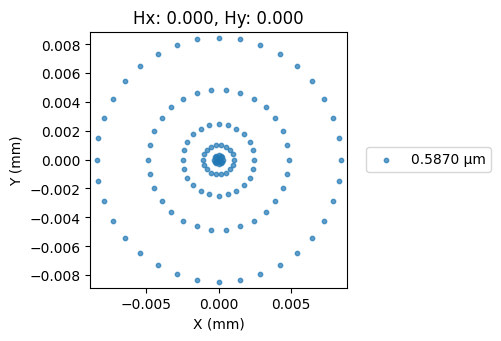

In [38]:
spot.view()

## Conclusions

- This notebook demonstrated how a random forest regressor can be trained to predict optimal lens parameters to achieve a minimal RMS spot size.
- Although we chose a random forest model, other (likely simpler) models could also have been used.
- Additional hyperparameter tuning or an expanded dataset would likely improve the model performance further.